For faster development speed, type `Ctrl + M, H` to view Google Colab keyboard shortcuts.

In [2]:
!pip install pytorch-lightning --quiet
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!pip install sdv --quiet

### Getting Started


#### Mounting your Google Drive

In [4]:
# np-pd-mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.lib.ufunclike import _deprecate_out_named_y

# Neural network packages
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import pytorch_lightning as pl 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Built-in
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time
import random
from typing import List, Tuple, Dict, Any
import logging
logging.getLogger('lightning').setLevel(0)

# sklearn
from sklearn import feature_selection
import sklearn.preprocessing
import sklearn.metrics
from sklearn import model_selection

Running the following cell will generate a message asking you to click on a link where you'll obtain an authorization code.

Paste that authorization code into the text box that appears below to access Google Drive from this notebook.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
!cd "/content/gdrive/MyDrive/" && ls # Displays directories in MyDrive/

 ApTSi		    Education	'School-Related Planning'   地位を申し込む
'Colab Notebooks'   Other	 SCIP
 Data		    Recordings	 temp


In [8]:
dir_path = os.path.join("/content/gdrive/MyDrive/Data", "NNsforGenomics")
os.path.exists(dir_path)

True

In [9]:
!cd {dir_path} && ls

ctgan  data  ml_models.py  neural_networks.py  preprocessing.py  __pycache__


In [10]:
import sys
sys.path.append(dir_path)
data_path = os.path.join(dir_path, "data")


In [11]:
import ctgan 
import preprocessing
import ml_models

In [9]:
class TabularDataset(torch.utils.data.Dataset): # inherit from torch
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        X, Y = [arr.astype(float) for arr in [X, Y]]
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y.reshape(-1,1))

        self.n_samples = X.shape[0]
        if self.X.shape[0] != self.Y.shape[0]:
            raise ValueError("Shape mismatch. X and Y should have the same " 
                + "number of rows")

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __len__(self):
        return self.n_samples

In [10]:
class LitFFNN(pl.LightningModule):
    # ----------------------------------
    # Initialize constants and NN architecture
    # ----------------------------------
    def __init__(self, X: np.ndarray, Y: np.ndarray, 
                 data_dir: str = data_path, batch_size = 50):
        """ Feed-Forward Neural Network System
        Args:
            X (np.ndarray): Feature matrix 
            Y (np.ndarray): Target matrix
        """
        super().__init__()
        # TODO: train-val-test splits
        self.X, self.Y = X, Y
        self.n_features = self.X.shape[1]

        # Hard-coded constants
        self.loss_fn = nn.NLLLoss()
        self.BATCH_SIZE = batch_size
        self.lr = 1e-1
        self.N_CLASSES = 3
        
        self.epoch = 0
        self.prog_bar = True
        # ----------------------------------
        # Architecture
        # ----------------------------------
        self.D_IN = self.X.shape[1]
        D_h_in = int((2/3) * self.D_IN)
        D_h_out = int((1/3) * self.D_IN) 
        # hidden_dim = int(np.sqrt(self.D_IN * self.N_CLASSES))
        # D_h_in = hidden_dim
        # D_h_out = hidden_dim

        self.fc_layers = nn.Sequential(
            nn.Linear(self.D_IN, D_h_in),
                nn.LeakyReLU(),
                nn.Dropout(p = 0.01),
            nn.Linear(D_h_in, D_h_out),
                nn.LeakyReLU(),
                nn.Dropout(p = 0.01),
            nn.Linear(D_h_out, self.N_CLASSES)
        )

        self.epoch_train_losses = []
        self.epoch_val_losses = []
        self.best_val_loss = np.infty
        self.best_val_epoch = 0

    def forward(self, x): 
        x = x.float()
        x = self.fc_layers(x)
        logits = F.log_softmax(input = x, dim = 1)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params = self.parameters(), lr = self.lr)
        return optimizer

    # ----------------------------------
    # Training, validation, and test steps
    # ----------------------------------

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.flatten().long()
        logits = self(x) 
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, 
                 prog_bar=self.prog_bar)
        return loss

    def validation_step(self, batch, batch_idx, val=True):
        x, y = batch
        y = y.flatten().long()
        # compute loss
        logits = self(x)
        loss = self.loss_fn(logits, y)
        # compute accuracy
        y_hat = self.predict(x)
        accuracy = self.accuracy(y_hat, y)
        # self.log interacts with TensorBoard
        self.log('val_loss', loss, on_step=True, on_epoch=True, 
                 prog_bar=self.prog_bar)
        self.log('val_acc', accuracy, on_step=False, on_epoch=True, 
            prog_bar=self.prog_bar)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, val = False)

    def training_epoch_end(self, outputs: List[Any]):
        # self.epoch_train_loss = np.array(outputs).mean()
        outputs: List[torch.Tensor] = [list(d.values())[0] for d in outputs]
        sum = torch.zeros(1, dtype=float).to(self.device)
        for batch_idx, batch_loss in enumerate(outputs):
            sum += batch_loss.to(self.device)
        avg_batch_loss = (sum / batch_idx)
        self.epoch_train_losses.append({avg_batch_loss[0].item()})

    def validation_epoch_end(self, outputs: List[Any]):
        sum = torch.zeros(1, dtype=float).to(self.device)
        for batch_idx, batch_loss in enumerate(outputs):
            sum += batch_loss.to(self.device)
        avg_batch_loss = (sum / batch_idx) 
        self.epoch_val_losses.append({avg_batch_loss[0].item()})        

    def custom_train(self, n_epochs, plot=True, verbose=False, plot_train=False):
        train_loader = self.train_dl
        val_loader = self.test_dl
        device=self.device
        self.network.to(device)

        train_losses, val_losses = [], []
        best_val_loss = np.infty
        best_val_epoch = 0
        early_stopping_buffer = 10
        epoch = 0
        best_params = None
        for epoch in range(n_epochs):
            train_loss, val_loss = 0.0, 0.0
  
            # Training
            self.network.train()
            for idx, batch in enumerate(train_loader):
                self.optimizer.zero_grad() # clears paramter gradient buffers
                inputs, targets = batch
                # transfer batch data to computation device
                inputs, targets = [
                    tensor.to(device) for tensor in [inputs, targets]]
                targets = targets.long() # converts dtype to Long
                output = self.network(inputs)
                loss = self.loss_fn(output, targets.flatten())
                # back propagation
                loss.backward()
                self.optimizer.step() # update model weights
                train_loss += loss.data.item()
                if (idx % 10 == 0) and verbose:
                    print(f"epoch {epoch+1}/{n_epochs}, batch {idx}.")
            train_loss = train_loss / len(train_loader)
            train_losses.append(train_loss)
           
            # Validation 
            self.network.eval()        
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = [tensor.to(device) for tensor in batch]
                targets = targets.long() # converts dtype to Long
                output = self.network(inputs)
                loss = self.loss_fn(output, targets.flatten())
                val_loss += loss.data.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
              best_params = self.network.parameters()
              best_val_loss = val_loss
              best_val_epoch = epoch
            
            # If validation loss fails to decrease for some number of epochs
            # end training
            if np.abs(epoch - best_val_epoch) > early_stopping_buffer:
              break
        
            print(f"Epoch: {epoch}, Training Loss: {train_loss:.3f}, "
                 +f"Validation loss: {val_loss:.3f}")
        
        #self.network.parameters = best_params
        self.best_val_loss = best_val_loss
        self.best_val_epoch = best_val_epoch
        if plot:
            skip_frames = 3
            fig, ax = plt.subplots()
            fig.tight_layout()
            if plot_train:
              ax.plot(np.arange(epoch + 1)[skip_frames:], 
                      train_losses[skip_frames:], '-', label="training set")
            ax.plot(np.arange(epoch + 1)[skip_frames:], 
                    val_losses[skip_frames:], '-', label="test set")
            ax.set(xlabel="Epoch", ylabel="Loss")
            ax.legend()
            plt.show() 
    
    # ----------------------------------
    # Data preparation hooks
    # ----------------------------------
    def prepare_data(self):
        """
        Args:
            X : feature matrix
            Y : target matrix
        """
        X, Y = self.X, self.Y
        global X_train, Y_train
        global X_val, Y_val
        global X_test, Y_test
        splits = np.array([84, 15, 1]) / 100
        train_size, val_size, test_size = splits
        # train-test split
        train_test_splits = model_selection.train_test_split(
            X, Y, test_size = test_size, random_state = 42)
        X_train, X_test, Y_train, Y_test = train_test_splits
        # train-val split
        relative_val_size = val_size / (train_size + val_size)
        train_val_splits = model_selection.train_test_split(
            X_train, Y_train, test_size = relative_val_size,
            random_state = 42)
        X_train, X_val, Y_train, Y_val = train_val_splits
        assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0] 

    def setup(self, stage=None):
        if stage in ["fit", None]:
            self.train_set = TabularDataset(X=X_train, Y=Y_train)
            self.val_set = TabularDataset(X=X_val, Y=Y_val)
        if stage in ["test", None]:
            self.test_set = TabularDataset(X=X_test, Y=Y_test)

    def get_dataloader(self, stage: str):
        if stage == "train":
            dataset = self.train_set
        if stage == "val":
            dataset = self.val_set
        if stage == "test":
            dataset = self.test_set
        dl = torch.utils.data.DataLoader(
            dataset = dataset, batch_size = self.BATCH_SIZE) 
        return dl 
        
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("train")
    def val_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("val")
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("test")
    
    # ----------------------------------
    # Helper functions
    # ----------------------------------
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        self.eval()
        x.to(self.device)
        logits = self(x)
        preds = torch.argmax(input = logits, dim=1)
        return preds

    def accuracy(self, pred: torch.Tensor, target: torch.Tensor):
        self.eval()
        accuracy = pl.metrics.functional.accuracy(pred, target)
        # pred, target = [t.flatten().int() for t in [pred, target]]
        # right = torch.sum(input = (pred == target)).item()
        # total = target.size()[0]
        # accuracy = right / total
        return accuracy

    def plot_losses(self, plot_train=True):
        skip_frames = 1
        fig, ax = plt.subplots()
        fig.tight_layout()

        n_epochs = len(self.epoch_val_losses)
        self.epoch_train_losses = [s.pop() for s in self.epoch_train_losses]
        self.epoch_val_losses = [s.pop() for s in self.epoch_val_losses]
        if plot_train:
            n_epochs = len(self.epoch_train_losses)
            ax.plot(np.arange(n_epochs)[skip_frames:], 
                    self.epoch_train_losses[skip_frames:], label="train")
        ax.plot(np.arange(n_epochs)[skip_frames:], 
                self.epoch_val_losses[1:][skip_frames:], label="val")
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.legend()
        plt.show()


In [12]:
try:
    print(f"X.shape: {X.shape},\tY.shape: {Y.shape}")
except:
    pp = preprocessing.Preprocessing()
    Y, names = pp.get_Y(data_path=data_path)
    X = pd.read_csv(os.path.join(data_path, "X.csv"))
    print(f"X.shape: {X.shape},\tY.shape: {Y.shape}")

X.shape: (4061, 25869),	Y.shape: (4061, 1)


In [13]:
chi2 = feature_selection.chi2
selectk = feature_selection.SelectKBest(chi2, k=100)
X_r: np.ndarray = selectk.fit_transform(X.values, Y.flatten())
X_r.shape

(4061, 100)

In [ ]:
# E

# Evaluating GAN reasonable GAN parameters



In [ ]:
REAL_DATA = X_r


In [13]:
try:
    print(ml.GANs, "\nGANs are already trained.")
except: 
    ml = ml_models.TabularGANs(X_r, Y)
    print("training GANs...")
    ml.trainGANs()
    print(f"GANs trained.\n{ml.GANs}")

training GANs...
GANs trained.


In [3]:
X_fake, Y_fake = ml.getFakeSamples(n = 1000)
print(X_fake.shape)
Y_fake = np.around(Y_fake).astype(int)
scaler = sklearn.preprocessing.MinMaxScaler()
X_fake = scaler.fit_transform(X_fake)
print(np.array([arr.shape for arr in [X_fake, Y_fake]]))

NameError: ignored

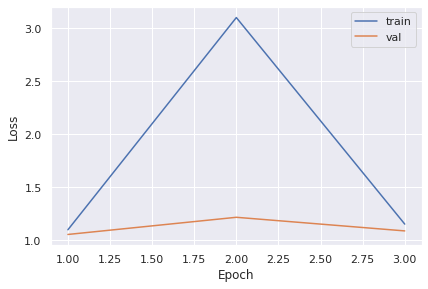

In [32]:
network = LitFFNN(X = X_fake, Y = Y_fake, data_dir=data_path)
trainer = pl.Trainer(max_epochs = 4, gpus = 0, fast_dev_run = False, 
    progress_bar_refresh_rate = 50)
trainer.fit(network)
network.plot_losses(plot_train = True)

In [37]:
pred = network.predict(torch.Tensor(X_r))
network.accuracy(pred, torch.Tensor(Y))

tensor(0.3755)

In [ ]:
def test_training_method(verbose = False):
    print("Testing training method: ")
    network = LitFFNN(X = X_fake, Y = Y_fake, data_dir=data_path)
    trainer = pl.Trainer(max_epochs = 4, gpus = 0, fast_dev_run=True, 
                         progress_bar_refresh_rate = 0)
    trainer.fit(network)
    if verbose:
        print(network)
    print("Test passed!\n")

def test_output_consistency():
    print("Testing model output consistency:")
    network = LitFFNN(X_r, Y)
    preds = []
    for i in range(2):
        pred = network.predict(torch.Tensor(X_r))
        preds.append(pred)

    overlap = np.array((preds[0] == preds[1]))
    t = overlap.sum() 
    f = overlap.size - t
    t, f = np.array([t, f]) / (t  + f) 
    print(f"Matched: {t:.2f} %,\tMismatched: {f:.2f} %.\n")

test_output_consistency()
test_training_method()

In [ ]:
network.accuracy(A, torch.Tensor(Y))

In [ ]:
output = predict(ml.X_test, ffnn.network)
print(f"Accuracy: {accuracy(ml.Y_test, output):.4f}")

In [ ]:
accuracy(Y_fake, predict(X_fake, ffnn.network))

In [ ]:
accuracy(ml.Y_test, predict(ml.X_test, ffnn.network))

In [ ]:
accuracy(ml.Y_train, predict(ml.X_train, ffnn.network))

In [ ]:
X_train.shape, X_val.shape, X_test.shape

```python
# ckpt
import logging
import torch.multiprocessing as mp
from torch.multiprocessing import Manager
from tqdm import tqdm
import time
#mp.set_start_method('spawn')# good solution !!!!

logging.getLogger('lightning').setLevel(0)

early_stop_callback = EarlyStopping(
   monitor='val_acc',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='max'
)


def train_model(accuracies, rank):
  start_time = time.time()
  print('rank: ', rank)
  A, indices = sample_from_data(100)
  model = LitFFNN(X = A, Y = Y, 
      data_dir = os.path.join(data_path, "temp"))
  trainer = pl.Trainer(gpus = 0, max_epochs=10, 
      progress_bar_refresh_rate=50, weights_summary=None,
      callbacks=[early_stop_callback], num_sanity_val_steps=0)
  trainer.fit(model)
  acc = model.accuracy(
    y_hat = model.predict(torch.Tensor(A.astype(float))),
    y = torch.Tensor(Y.astype(float))).item()
  accuracies.append(acc)

with Manager() as manager:
  accuracies = manager.list()  # <-- can be shared between processes.
  indices = manager.list()  # <-- can be shared between processes.
  processes = []
  num_processes = 10
  for i in tqdm(range(1)):
    for rank in range(num_processes):
      p = mp.Process(target=train_model, args=(accuracies, rank,))
      p.start()
      processes.append(p)
    for p in processes:
      p.join()
  accuracies = list(accuracies)
  ```